In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from data_gen_distance import *
from pointcloud_utils_functions_v2 import *
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = 'cpu'

Total distance images: 5000
Train distance images: 4500
Validation distance images: 500


### Generador de Train y Valid

In [2]:
class IterDataset(torch.utils.data.IterableDataset):
    def __init__(self, generator):
        self.generator = generator

    def __iter__(self):
        return self.generator()
    
train_dataset = IterDataset(train_data_generator)
valid_dataset = IterDataset(valid_data_generator)

### Custom Convolutional Layer

In [3]:
class Upsampling_Conv(nn.Module):
    def __init__(self, upsampling_factor=2, n_channels=1, padding=(0,1), stride=(1,1)): 
        #padding:(agregar n filas, agregar n columnas)
        #stride(de a cuantas filas me muevo:de a cuantas columnas me muevo)
        super(Upsampling_Conv, self).__init__()

        self.kernel_size = (2,3)
        self.padding = padding
        self.stride = stride
        self.n_channels = n_channels
        self.upsamplig_factor = upsampling_factor
        self.distance_kernel_x2 = torch.tensor([torch.sqrt(torch.tensor(2)), 1, torch.sqrt(torch.tensor(2)), torch.sqrt(torch.tensor(2)), 1, torch.sqrt(torch.tensor(2))], device=device) #Distancias Euclídeas para un kernel de 3x3 desde un pixel central de posición (1,1)
                                                                                                                           #sin considerar los píxeles (1,0) y (1,2) porque esos son los nuevos píxeles a calcular también
        self.distance_kernel_up = torch.tensor([torch.sqrt(torch.tensor(2)), 1, torch.sqrt(torch.tensor(2)), torch.sqrt(torch.tensor(10)), 3, torch.sqrt(torch.tensor(10))], device=device)
        self.distance_kernel_mid = torch.tensor([torch.sqrt(torch.tensor(5)), 2, torch.sqrt(torch.tensor(5)), torch.sqrt(torch.tensor(5)), 2, torch.sqrt(torch.tensor(5))], device=device) 
        self.distance_kernel_down = torch.tensor([torch.sqrt(torch.tensor(10)), 3, torch.sqrt(torch.tensor(10)), torch.sqrt(torch.tensor(2)), 1, torch.sqrt(torch.tensor(2))], device=device)  
        #self.lambda_wi = nn.Parameter(torch.tensor([0.5]))
        self.lambda_wi = nn.Parameter(torch.randn(()))
   
    def forward(self, x):

        n_batches = x.shape[0]
        height = x.shape[2] * self.upsamplig_factor
        width = x.shape[3]
        result = torch.zeros([n_batches, self.n_channels, height, width], dtype=torch.float32, device=device)

        if self.upsamplig_factor == 2:
            even_raw_id = torch.arange(0, result.shape[2], 2)
            odd_raw_id = torch.arange(1, result.shape[2]-1, 2) #El -1 soluciona el problema que causa la última fila de la imagen resultante, al no poser ser escaneada por la convolución

            pixels = self.get_NewPixelsValues(x) #pixels = [batch, 1, filas, columnas]

            result[:,:,even_raw_id,:] = x
            result[:,:,odd_raw_id,:] = pixels
            result = torch.dstack((result[:,:,:-1,:], x[:,:,-1:,:])) #Repito la última fila
            #print(result.shape)
            #result[:,:,-1,:] = x[:,:,-1,:]       

        elif self.upsamplig_factor == 4:
            x_raw_id = torch.arange(0, result.shape[2], 4) #Filas en matriz result ocupadas por valores originales de x
            #new_raw_id = torch.arange(0,result.shape[2],1)[torch.arange(0,result.shape[2],1) % 4 != 0] #Filas en matriz result ocupadas por valores interpolados
            up_raw_id = torch.arange(1,result.shape[2]-3,4) #Filas en matriz result ocupadas por valores interpolados de pixeles superiores, considerando que para interpolar x4 se necesitan 3 nuevos valores
            mid_raw_id = torch.arange(2,result.shape[2]-3,4) #Filas en matriz result ocupadas por valores interpolados de pixeles intermedios, considerando que para interpolar x4 se necesitan 3 nuevos valores
            down_raw_id = torch.arange(3,result.shape[2]-3,4) #Filas en matriz result ocupadas por valores interpolados de pixeles inferiores, considerando que para interpolar x4 se necesitan 3 nuevos valores
            
            pixels = self.get_NewPixelsValues(x)

            result[:,:,x_raw_id,:] = x
            #result[:,:,-3:,:] = x[:,:,-1,:] #Últimas 3 filas iguales
            result = torch.dstack((result[:,:,:-3,:], x[:,:,-1:,:], x[:,:,-1:,:], x[:,:,-1:,:])) #Últimas 3 filas iguales
            result[:,:,up_raw_id,:] = pixels[0]
            result[:,:,mid_raw_id,:] = pixels[1]
            result[:,:,down_raw_id,:] = pixels[2]
            
        else:
            print("ERROR: Wrong Upsampling factor")
        return result  
    
    def weight_function(self, kernel, distance_kernel):
        nonzero_pos = [kernel != 0][0].type(torch.int)
        #print(self.lambda_wi.device, self.distance_kernel.device, kernel.device, nonzero_pos.device)
        y = torch.exp(-self.lambda_wi*distance_kernel) * (2 / (1 + torch.exp(kernel - torch.min(kernel)))) * nonzero_pos #Solo considero los valores que cumplen la condición de que sean mayores que 0
        return y

    def get_NewPixelsValues(self, x):
        windows = F.unfold(x, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride)
        windows = windows.transpose(1, 2) #Obtener los valores de la ventana o kernel ordenados por fila, donde cada fila representa una ventana serializada

        if self.upsamplig_factor == 2:
            #print(self.distance_kernel_up.shape, windows.shape)
            wi = self.weight_function(windows, self.distance_kernel_x2)
            pixels_value_num = torch.multiply(windows, wi).sum(2) #Sumar todos los elementos de una fila para obtener el valor final del pixel
            pixels_value_den = torch.sum(wi, dim=2)
            pixels_value_den[pixels_value_den == 0] = 1 #Control para evitar errores en la división
            pixels = pixels_value_num/pixels_value_den
            pixels = pixels.view(x.shape[0], x.shape[1], -1, x.shape[-1])

        elif self.upsamplig_factor == 4:
            #print(self.distance_kernel_up.shape, windows.shape)
            wi_up = self.weight_function(windows, self.distance_kernel_up)
            wi_mid = self.weight_function(windows, self.distance_kernel_mid)
            wi_down = self.weight_function(windows, self.distance_kernel_down)
            
            pixels_value_num_up = torch.multiply(windows, wi_up).sum(2) #Sumar todos los elementos de una fila para obtener el valor final del pixel
            pixels_value_num_mid = torch.multiply(windows, wi_mid).sum(2)
            pixels_value_num_down = torch.multiply(windows, wi_down).sum(2)

            pixels_value_den_up = torch.sum(wi_up, dim=2)
            pixels_value_den_mid = torch.sum(wi_mid, dim=2)
            pixels_value_den_down = torch.sum(wi_down, dim=2)

            pixels_value_den_up[pixels_value_den_up == 0] = 1 #Control para evitar errores en la división
            pixels_value_den_mid[pixels_value_den_mid == 0] = 1 #Control para evitar errores en la división
            pixels_value_den_down[pixels_value_den_down == 0] = 1 #Control para evitar errores en la división

            pixels_up = (pixels_value_num_up/pixels_value_den_up).view(x.shape[0], x.shape[1], -1, x.shape[-1])
            pixels_mid = (pixels_value_num_mid/pixels_value_den_mid).view(x.shape[0], x.shape[1], -1, x.shape[-1])
            pixels_down = (pixels_value_num_down/pixels_value_den_down).view(x.shape[0], x.shape[1], -1, x.shape[-1])
            
            pixels = [pixels_up, pixels_mid, pixels_down]

        else:
            print("ERROR: Wrong Upsampling factor") 
        return pixels

    def string(self):
        return f'Lambda_wi = {self.lambda_wi.item()}'


### Entorno de entrenamiento

In [4]:
class myNet(nn.Module):
    def __init__(self): 
        super(myNet, self).__init__()
        self.custom_up_layer_1 = Upsampling_Conv()
        self.custom_up_layer_2 = Upsampling_Conv()
        
    def forward(self, input):
        x =  self.custom_up_layer_1(input)
        output = self.custom_up_layer_2(x)
        return output

batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

#model = myNet()
model = Upsampling_Conv(upsampling_factor=4)
model.to(device)

loss_fn = torch.nn.L1Loss()
#loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_one_epoch(epoch_index):
    running_loss = 0

    for i, data in enumerate(tqdm(train_dataloader)):
    #for i, data in enumerate(train_dataloader):
        lrimgs, hrimgs = data
        lrimgs = lrimgs.to(device)
        hrimgs = hrimgs.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(lrimgs)
        
        # Compute the loss and its gradients
        #print(outputs.shape, labels.shape)

        loss = loss_fn(outputs, hrimgs)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

    return running_loss / (i + 1)

epoch_number = 0
EPOCHS = 20

for epoch in range(EPOCHS):

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)

    # We don't need gradients on to do reporting
    model.train(False) #Evaluation
    running_vloss = 0.0
    with torch.no_grad():
        for i, vdata in enumerate(valid_dataloader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss
    avg_vloss = running_vloss / (i + 1)

    #print(f'Epoch {epoch_number + 1} - Train_loss: {avg_loss} - Valid_loss: {avg_vloss} - Result_layer_1: {model.custom_up_layer_1.string()}')
    print(f'Epoch {epoch_number + 1} - Train_loss: {avg_loss} - Valid_loss: {avg_vloss} - {model.string()}')

    # Track best performance, and save the best model parameter
    if epoch == 0:
        best_vloss = avg_vloss
    else:
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            best_lambda_wi = model.lambda_wi.item()
            best_epoch = epoch_number + 1
    #    model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    #    torch.save(model.state_dict(), model_path)

    epoch_number += 1

print(f'Best lambda_wi: {best_lambda_wi} - Valid_loss: {best_vloss} - Epoch: {best_epoch}')

36it [00:06,  5.37it/s]


Epoch 1 - Train_loss: 0.036186514525777765 - Valid_loss: 0.03480388596653938 - Lambda_wi = 1.064371109008789


36it [00:06,  5.43it/s]


Epoch 2 - Train_loss: 0.03605324081662628 - Valid_loss: 0.03584708645939827 - Lambda_wi = 1.028385043144226


36it [00:06,  5.24it/s]


Epoch 3 - Train_loss: 0.03608968212372727 - Valid_loss: 0.036268450319767 - Lambda_wi = 0.9920283555984497


36it [00:07,  5.11it/s]


Epoch 4 - Train_loss: 0.035737817279166646 - Valid_loss: 0.03411503881216049 - Lambda_wi = 0.9562856554985046


36it [00:06,  5.21it/s]


Epoch 5 - Train_loss: 0.03597761638876465 - Valid_loss: 0.034820593893527985 - Lambda_wi = 0.920226514339447


36it [00:06,  5.18it/s]


Epoch 6 - Train_loss: 0.03554182592779398 - Valid_loss: 0.034927234053611755 - Lambda_wi = 0.8839884996414185


36it [00:06,  5.18it/s]


Epoch 7 - Train_loss: 0.035294684995379716 - Valid_loss: 0.03547783941030502 - Lambda_wi = 0.8482860922813416


36it [00:06,  5.23it/s]


Epoch 8 - Train_loss: 0.03587589681976371 - Valid_loss: 0.03543510288000107 - Lambda_wi = 0.8127481937408447


36it [00:07,  5.14it/s]


Epoch 9 - Train_loss: 0.03550697107695871 - Valid_loss: 0.035056985914707184 - Lambda_wi = 0.7782477736473083


36it [00:06,  5.21it/s]


Epoch 10 - Train_loss: 0.03567916558434566 - Valid_loss: 0.034577228128910065 - Lambda_wi = 0.7448318600654602


36it [00:06,  5.66it/s]


Epoch 11 - Train_loss: 0.03508253302425146 - Valid_loss: 0.035692982375621796 - Lambda_wi = 0.7129828929901123


36it [00:06,  5.60it/s]


Epoch 12 - Train_loss: 0.0352404098957777 - Valid_loss: 0.03532971441745758 - Lambda_wi = 0.6825452446937561


36it [00:06,  5.75it/s]


Epoch 13 - Train_loss: 0.03551152814179659 - Valid_loss: 0.03491441532969475 - Lambda_wi = 0.6527565121650696


36it [00:06,  5.28it/s]


Epoch 14 - Train_loss: 0.03516343877547317 - Valid_loss: 0.03336818143725395 - Lambda_wi = 0.624928891658783


36it [00:06,  5.18it/s]


Epoch 15 - Train_loss: 0.03497759014781979 - Valid_loss: 0.033778656274080276 - Lambda_wi = 0.5987786054611206


36it [00:06,  5.77it/s]


Epoch 16 - Train_loss: 0.03501361204932133 - Valid_loss: 0.035237930715084076 - Lambda_wi = 0.5745273232460022


36it [00:06,  5.25it/s]


Epoch 17 - Train_loss: 0.035020496799714036 - Valid_loss: 0.03497232496738434 - Lambda_wi = 0.5512906312942505


36it [00:06,  5.95it/s]


Epoch 18 - Train_loss: 0.03517066319990489 - Valid_loss: 0.035101477056741714 - Lambda_wi = 0.5287766456604004


36it [00:06,  5.23it/s]


Epoch 19 - Train_loss: 0.03545164679073625 - Valid_loss: 0.03465384617447853 - Lambda_wi = 0.5087053179740906


36it [00:06,  5.32it/s]


Epoch 20 - Train_loss: 0.035358456377353936 - Valid_loss: 0.034595247358083725 - Lambda_wi = 0.4900098443031311
Best lambda_wi: 0.624928891658783 - Valid_loss: 0.03336818143725395 - Epoch: 14


### Testing

In [5]:
def test(model, lr_image, hr_image):
    with torch.no_grad():
        model.eval()

        lr_image = lr_image.to(device)
        hr_image = hr_image.to(device)
        outputs = model(lr_image)

        mse = F.mse_loss(outputs, hr_image)
    
    return outputs, mse

test_bin_PATH = r'D:\Nicolas\Posgrado\Trabajos y Tesis\LIDAR\Datasets LIDAR\kitti\kitti_3d_object\testing\velodyne\000001.bin'
#test_PATH = r'D:\Nicolas\Posgrado\Trabajos y Tesis\LIDAR\Datasets LIDAR\kitti\range_images_64ch_1024_filter_ego_motion\drive_0001_0000000000.npy'
pointcloud = read_bin(test_bin_PATH)
hr_range_distance_image = pointcloud_to_range_image(pointcloud, filter_ego_compensed=True, kind='distance', size=(64,1024))
#hr_range_distance_image = np.load(test_PATH)

downsampling_factor = 4
ind = np.arange(0,64,downsampling_factor)
lr_range_distance_image = hr_range_distance_image[ind] / kitti_max_distance
hr_range_distance_image = hr_range_distance_image / kitti_max_distance
lr_range_distance_image = torch.from_numpy(lr_range_distance_image).view(1,1,lr_range_distance_image.shape[0],lr_range_distance_image.shape[1])
hr_range_distance_image = torch.from_numpy(hr_range_distance_image).view(1,1,hr_range_distance_image.shape[0],hr_range_distance_image.shape[1])

output, mse = test(model, lr_range_distance_image, hr_range_distance_image)
output_image_format = output.cpu().numpy()[0][0]
model.string()


'Lambda_wi = 0.37732478976249695'

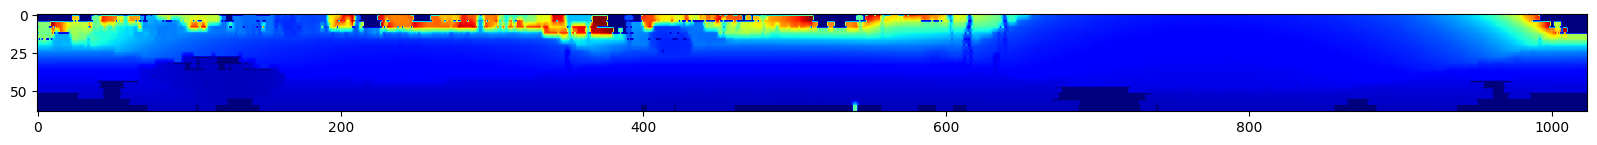

In [6]:
plt.figure(figsize=(20,8))
plt.imshow(output_image_format, cmap='jet')
plt.show()

### Guardar Nube de Puntos

In [7]:
pointcloud = range_image_to_pointcloud(output_image_format * kitti_max_distance)

save_PATH = r'D:\Nicolas\Posgrado\Trabajos y Tesis\LIDAR\LIDAR_super_resolution\Scripts\evaluacion_resultados\nubes_de_puntos\ego_motion_filtered\a.ply'
save_ply(pointcloud, save_PATH)